<a href="https://colab.research.google.com/github/takoroy/mypytorch-memo/blob/master/SpatialTransformerNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [SPATIAL TRANSFORMER NETWORKS TUTORIAL](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html) のメモ

## 環境のセットアップ

In [1]:
# PyTorchのインストール
! pip install torch torchvision

    100% |████████████████████████████████| 591.8MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x619f8000 @  0x7f20d815f2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 22.9MB/s 
    100% |████████████████████████████████| 2.0MB 5.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
import torch
torch.__version__

'1.0.0'

## パッケージのimport、cudaの利用

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')  # colab上では、matplotlibに独自のスタイルが適用されていますが、見にくいので通常のmatplotlibのスタイルに戻しています。

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# ちゃんと"cuda"になっていることを確認しましょう。"cuda"になっていないときは、Colaboratoryのランタイムを選択し直しましょう。
device

device(type='cuda')

## データセットの作成

MNISTをそのままでも良いのですが、より難しい[こちら](https://github.com/oarriaga/STN.keras)のデータを使わせていただきましょう。

In [6]:
! wget https://github.com/oarriaga/STN.keras/raw/master/datasets/mnist_cluttered_60x60_6distortions.npz -O mnist.npz

--2019-01-08 12:06:23--  https://github.com/oarriaga/STN.keras/raw/master/datasets/mnist_cluttered_60x60_6distortions.npz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oarriaga/STN.keras/master/datasets/mnist_cluttered_60x60_6distortions.npz [following]
--2019-01-08 12:06:24--  https://raw.githubusercontent.com/oarriaga/STN.keras/master/datasets/mnist_cluttered_60x60_6distortions.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43046126 (41M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  41.05M   130MB/s    in 0.3s    

201

In [0]:
data = np.load('mnist.npz')

In [0]:
from torch.utils.data import Dataset, DataLoader

class MNISTDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx].reshape(1, 60, 60), np.argmax(self.y[idx])
    

In [0]:
train_dataset = MNISTDataset(data['x_train'], data['y_train'])
test_dataset = MNISTDataset(data['x_test'], data['y_test'])

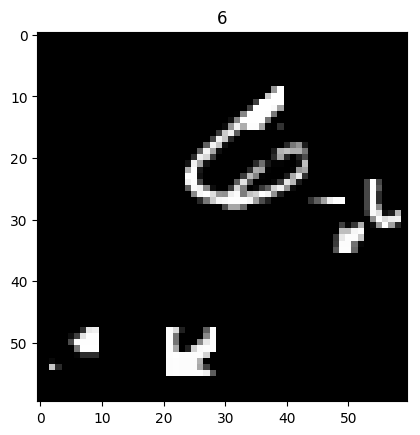

In [10]:
# こんな感じのきたない画像です。
plt.title(train_dataset[11][1])
plt.imshow(train_dataset[11][0].transpose(1, 2, 0)[:,:,0], cmap="gray")

In [11]:
# (0, 1)に正規化されています
test_dataset[0][0].min(), test_dataset[0][0].max()

(0.0, 1.0)

In [0]:
# Training dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# Test dataloader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

## ネットワークの定義

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.AvgPool2d(2, stride=2),                   # [1, 60, 60] -> [1, 30, 30]
            nn.Conv2d(1, 10, kernel_size=5),        # [1, 30, 30] -> [10, 26, 26]
            nn.ReLU(True),
            nn.Conv2d(10, 20, kernel_size=3),      # [10, 26, 26] -> [20, 24, 24]
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),                    # [20, 24, 24] -> [20, 12, 12]
            nn.Conv2d(20, 20, kernel_size=3),      # [20, 12, 12] -> [20, 10, 10]
            nn.Dropout2d(),
            nn.MaxPool2d(2, stride=2)                     # [20, 10, 10] -> [20, 5, 5]
        )
        
        self.fc_clf = nn.Sequential(
            nn.Linear(20*5*5, 50),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(50, 10)
        )

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),       # [1, 60, 60] -> [8, 56, 56]
            nn.MaxPool2d(2, stride=2),                # [8, 56, 56] -> [8, 28, 28]
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),     # [8, 28, 28] -> [10, 24, 24]
            nn.MaxPool2d(2, stride=2),                # [10, 24, 24] -> [10, 12, 12]
            nn.ReLU(True),
            nn.Conv2d(10, 10, kernel_size=3),   # [10, 12, 12] -> [10, 10, 10]
            nn.MaxPool2d(2, stride=2),                 # [10, 10, 10] -> [10, 5, 5]
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 5 * 5, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        # この初期化によって、未学習時は恒等変換を行うようにする。
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 5 * 5)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        
        # Perform the usual forward pass
        x = self.classifier(x)
        x = x.view(-1, 20 * 5 * 5)
        x = self.fc_clf(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

## オプティマイザと学習・評価関数の作成

In [0]:
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.001)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target,  reduction='sum').item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## 可視化のための関数の作成

In [0]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
  
    plt.figure(figsize=(12, 8), dpi=300)
  
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

## 学習と評価

In [19]:
for epoch in range(1, 50 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.294207
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.298687

Test set: Average loss: 2.2995, Accuracy: 1119/10000 (11%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.298506
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.303563

Test set: Average loss: 2.2985, Accuracy: 1119/10000 (11%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.297125
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.298995

Test set: Average loss: 2.2959, Accuracy: 1173/10000 (12%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.298651
Train Epoch: 4 [32000/50000 (64%)]	Loss: 2.298210

Test set: Average loss: 2.2885, Accuracy: 1272/10000 (13%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 2.275639
Train Epoch: 5 [32000/50000 (64%)]	Loss: 2.263967

Test set: Average loss: 2.2548, Accuracy: 1695/10000 (17%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 2.237725
Train Epoch: 6 [32000/50000 (64%)]	Loss: 2.288352

Test set: Average loss: 2.1850, Accuracy: 1905/10000 (19%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 2.249822
Train Epoch: 7 [320

## アフィン変換結果の可視化

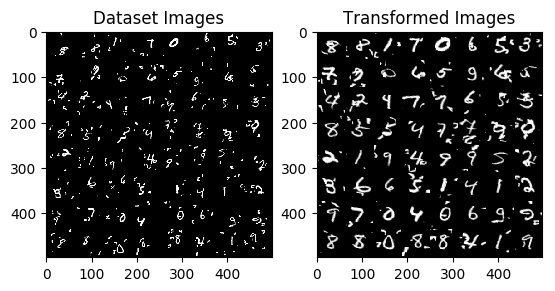

In [20]:
# Visualize the STN transformation on some input batch
visualize_stn()
plt.savefig("stn_result.png")
plt.show()

In [0]:
# 画像のダウンロード
from google.colab import files
files.download("stn_result.png") 

#APPENDIX

F.affine_gridの処理結果の可視化

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import cv2



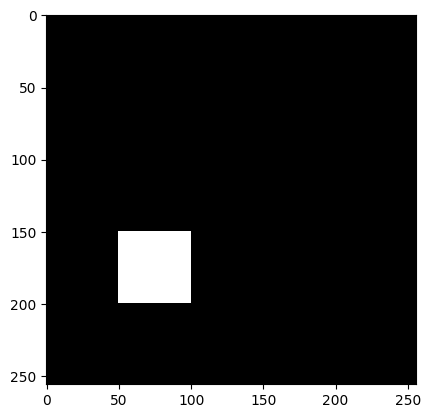

In [23]:
# 元画像
org_img = np.zeros((256, 256))
org_img[150:200, 50:100] = 1.0
plt.imshow(org_img, cmap="gray")


In [0]:
org_tensor = torch.Tensor([[org_img]])

##恒等変換

In [0]:
theta = torch.FloatTensor([[[1, 0, 0], [0, 1, 0]]])
grid = F.affine_grid(theta, org_tensor.size())

In [26]:
grid.min(), grid.max()

(tensor(-1.), tensor(1.))

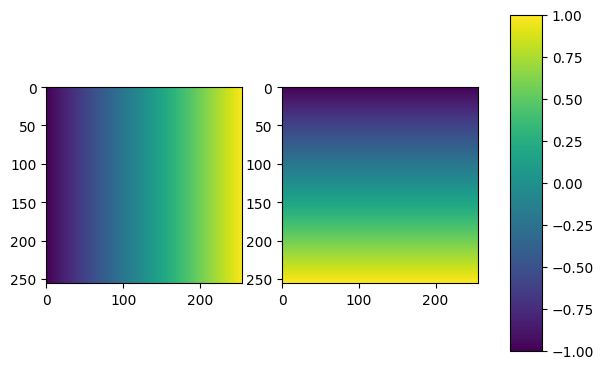

In [27]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(grid[0, :, :, 0])
im = axs[1].imshow(grid[0, :, :, 1])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

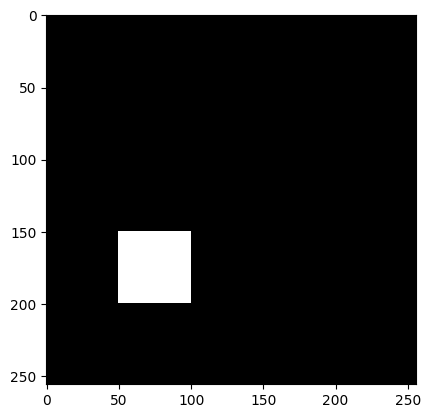

In [28]:
transformed = F.grid_sample(org_tensor, grid)[0, 0]
plt.imshow(transformed, cmap="gray")

##回転・拡大・平行移動



In [0]:
theta = torch.FloatTensor([[[np.cos(np.pi/4), np.sin(np.pi/4), 0], [-np.sin(np.pi/4), np.cos(np.pi/4), 0]]])
grid = F.affine_grid(theta, org_tensor.size())

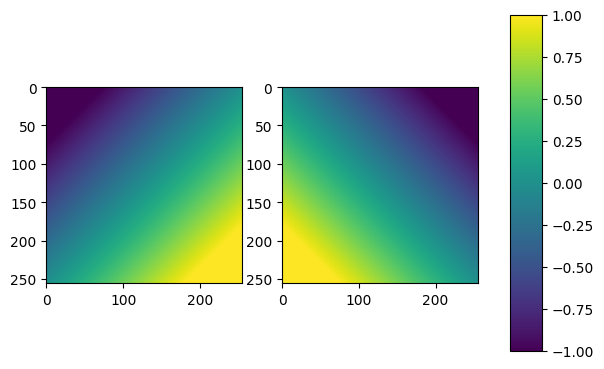

In [30]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(grid[0, :, :, 0], vmin=-1, vmax=1)
im = axs[1].imshow(grid[0, :, :, 1], vmin=-1, vmax=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [31]:
grid.min(), grid.max()

(tensor(-1.4142), tensor(1.4142))

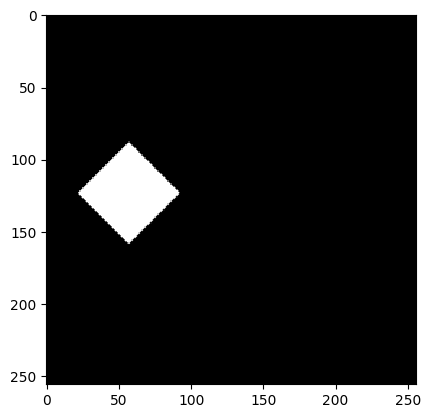

In [32]:
transformed = F.grid_sample(org_tensor, grid)[0, 0]
plt.imshow(transformed, cmap="gray")